In [ ]:
# Restart with command below if keras uses Theano backend
# KERAS_BACKEND=tensorflow jupyter notebook --no-browser

In [ ]:
# Use command below in terminal to view the network's TensorBoard
# tensorboard --logdir=./logs

# Then go to EC2 Instance's public DNS port 6006

# Verifying network architecture on UCF Sports Action Dataset  

## Results  (toward the bottom)
After a quick test of **50 epochs**, the network achieves the following. It is predicting on 13 action classes, so the random baseline would be ~7.6%  

**Top 1 Validation Accuracy: ~83%**  
**Top 3 Validation Accuracy: ~91%**   
**Top 1 Test Accuracy: 93%**  
**Top 3 Test Accuracy: 96%**

## Modifications to network to handle multi class targets  
1. Changed final activation from **`sigmoid`** to **`softmax`**  
2. Changed optimization from **`rmsprop`** to **`adam`**  
3. Changed loss function from **`binary_crossentropy`** to **`categorical_crossentropy`**  
4. Reduced size of LSTM Cell from **1024** to **256**  
5. Reduced size of Dense layers from **512** to **128** and **64**  

## UCF Sports Action Dataset  
* 13 action classes  
* 150 total samples / clips  
* between 6 and 22 samples of each class  
* 720 x 480 original resolution  
* 10 fps  

## Preprocessing  
* down sample to 10 frames for each clip  
* down sample to 178 x 178 resolution  
* center crop each frame  
* split into:  
  * Test: 30 samples  
  * Validation: 24 samples  
  * Train: 96 samples
  
  ***


# LieDetector network "works" but doesn't learn (not better than random)  

## Why I think the LieDetector in its current form isn't learning
Pretty sure the issue is data. Lie detection with a ConvNet would have to capture subtle changes in facial adjustments, eye movement, and head and hand movement. These things occur in a tenth of a second or less. While the frame rate for the video clips is 30 fps, the clips are 10-60 seconds in length. I would probably have to run nearly all frames through the network at a pretty high resolution to hope to capture the relevant features. I'm currently down sampling to 30 frames of centered 178x178 resolution. Not enough! On top of that, I only have a set of 120 videos / samples.

### What needs to happen  
** * More GPUs / More Time**  
** * Train on full resolution**  
** * Train on full frames**  
** * More samples**

### Other things to try:  
* play around with hyperparameters  
* play around with layers  
* play arond with hidden layer activations
* frame augmentation  
* manually adjust videos where subject is not centered  

***

# Packages

In [1]:
import numpy as np
from time import sleep
import sys
import random

import tensorflow as tf
import keras
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Input, Dense, Activation, TimeDistributed, LSTM, Dropout, Lambda
from keras.preprocessing import image
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from keras.metrics import top_k_categorical_accuracy

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from PIL import Image
import imageio
#imageio.plugins.ffmpeg.download()

import scipy
import os

Using TensorFlow backend.
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Parameters

In [80]:
VIDEO_FOLDER = (os.getcwd() + '/videos/Clips')
ACTION_FOLDER = (os.getcwd() + '/sports_clips/ucf_sports_actions/ucf_action')
EPOCHS = 50
BATCH_SIZE = 32
FRAME_SQUARE_DIM = 178
FRAMES_PER_VIDEO = 10
DROP_PROB = 0.3
LSTM_UNITS = 256
FIRST_DENSE_UNITS = 128
SECOND_DENSE_UNITS = 64
TEST_SIZE = 0.2

In [81]:
keras.backend.clear_session()

In [83]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

In [84]:
keras.backend.set_learning_phase(0)

# Model Architecture

In [85]:
def get_model(frames_per_video, frame_square_dim, drop_prob, lstm_units, first_dense_units, second_dense_units):
    # Video file placeholder. Shape = (# of frames, frame-width, frame-length, # of frame-channels (i.e. rgb))
    video_input = Input(shape=(frames_per_video, frame_square_dim, frame_square_dim, 3), name='video_input')

    # TRANSFER LEARNING LAYER
    # Initialize CNN with weights from InceptionV3 trained on Imagenet.
    IncV3 = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Freeze Inception layers, so we can use the already trained weights that represent lower level
    # vision and pattern recognition.
    IncV3.trainable = False
    
    # TIME DISTRIBUTION LAYER
    # Run each frame through an InceptionV3 CNN layer.
    encoded_frames = TimeDistributed(Lambda(lambda x: IncV3(x)), name='encoded_frames')(video_input)

    # LSTM LAYER
    # Run each frames CNN output through the LSTM layer.
    encoded_vid = LSTM(units=lstm_units, dropout=drop_prob, name='encoded_vid')(encoded_frames)

    # ADDITIONAL LAYERS TO TRAIN NEW CLASSES from our new video footage.
    # Add fully-connected layers before predictions.
    first_dense = Dense(units=first_dense_units, activation='relu', name='first_dense')(encoded_vid)
    second_dense = Dense(units=second_dense_units, activation='relu', name='second_dense')(first_dense)

    # Add a logistic layer with 2 new classes - "Lying" and "Truth".
    predictions = Dense(13, activation='softmax', name='predictions')(second_dense)

    # Throw it all into a Model object.
    model = Model(inputs=[video_input], outputs=predictions)

    # Top K Accuracy
    def Top3Acc(x, y):
        return top_k_categorical_accuracy(x, y, k=3)
    
    # Compile the model.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Top3Acc])
    
    return model

In [86]:
model = get_model(FRAMES_PER_VIDEO, FRAME_SQUARE_DIM, DROP_PROB, LSTM_UNITS, FIRST_DENSE_UNITS, SECOND_DENSE_UNITS)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video_input (InputLayer)     (None, 10, 178, 178, 3)   0         
_________________________________________________________________
encoded_frames (TimeDistribu (None, 10, 2048)          0         
_________________________________________________________________
encoded_vid (LSTM)           (None, 256)               2360320   
_________________________________________________________________
first_dense (Dense)          (None, 128)               32896     
_________________________________________________________________
second_dense (Dense)         (None, 64)                8256      
_________________________________________________________________
predictions (Dense)          (None, 13)                845       
Total params: 2,402,317
Trainable params: 2,402,317
Non-trainable params: 0
_________________________________________________________________


# Create Class Folders 

In [34]:
# Make Frames directories in Truthful and Deceptive folders
if not os.path.exists((VIDEO_FOLDER + '/Truthful/Frames')):
    os.mkdir(VIDEO_FOLDER + '/Truthful/Frames')
if not os.path.exists((VIDEO_FOLDER + '/Deceptive/Frames')):
    os.mkdir(VIDEO_FOLDER + '/Deceptive/Frames')

# Make Frames directories in each Action folder
for action_folder in os.listdir(ACTION_FOLDER):
    if not os.path.exists((ACTION_FOLDER + '/' + str(action_folder) +'/Frames')):
        os.mkdir((ACTION_FOLDER + '/' + str(action_folder) +'/Frames'))

# Preprocessing Functions 

In [88]:
def resize_and_crop(frame, square_dim):
    # get aspect ratio
    aspect = frame.size[0]/frame.size[1]
    
    # resize to 178 on shortest side and keep original aspect ratio
    frame = frame.resize((int(square_dim*aspect), square_dim))
    
    # crop 178 square from center
    half_the_width = frame.size[0] / 2
    half_the_height = frame.size[1] / 2
    frame = frame.crop(
        (
            half_the_width - (square_dim/2),
            half_the_height - (square_dim/2),
            half_the_width + (square_dim/2),
            half_the_height + (square_dim/2)
        )
    )
    
    return frame

## UCF Sports Action Set Processing Functions

In [89]:
def get_action_frames_from_videos(folder, frames_per_video, frame_square_dim):
    
    # Throw out any old frames.
    for existing_frame in os.listdir((folder + '/Frames/')):
        os.remove((folder + '/Frames/' + existing_frame))
    
    # get one video at a time in the folder
    print("Down sampling video frames.")
    vid_counter = 0
    for video_folder in sorted(os.listdir(folder)):
        vid_counter += 1
        
        if video_folder not in ['Frames']:
            # printing status
            sys.stdout.write('\r')
            sys.stdout.flush()
            sys.stdout.write('Getting frames for video ' + str(vid_counter) + ' of ' + str(len(os.listdir(folder))-1))
            sys.stdout.flush()
            
            frame_set = []
            for file in sorted(os.listdir((folder + '/' + video_folder))):
                if len((folder + '/' + video_folder + '/' + file).rsplit('.', 1)) > 1:
                    if (folder + '/' + video_folder + '/' + file).rsplit('.', 1)[1] == 'jpg':
                        frame_set.append((folder + '/' + video_folder + '/' + file))
            
            if len(frame_set) == 0:
                for file in sorted(os.listdir((folder + '/' + video_folder + '/jpeg'))):
                    if len((folder + '/' + video_folder + '/' + file).rsplit('.', 1)) > 1:
                        if (folder + '/' + video_folder + '/' + file).rsplit('.', 1)[1] == 'jpg':
                            frame_set.append((folder + '/' + video_folder + '/jpeg' + '/' + file))
                        
                        
            step = len(frame_set) / frames_per_video
            frames_to_get = range(0, len(frame_set), int(step))

            frames = []
            for i in frames_to_get:
                frames.append(i)

            # only get number of frames equal to FRAMES_PER_VIDEO if there are more
            frames = frames[:frames_per_video]

            # Resize, crop, and save each frame in the Frames folder
            ## ex: (os.getcwd + '/videos/Clips/Truthful/Frames') for Truth videos
            f = 20
            for frame in frames:
                this_frame = Image.open(frame_set[frame])
                this_frame = resize_and_crop(this_frame, frame_square_dim)
                this_frame.save((folder + '/Frames/' + video_folder + '_01' + str(f) + '.jpg'))
                f += 1
                
    print('\n')
    print('Complete!')
    print('')

In [96]:
def get_action_data(folder, frames_per_video):
    X = []
    y = []

    for vid_type in sorted(os.listdir(folder)):
        if not vid_type.startswith('.'):
            label = vid_type
            
            video_tensor = []
            frame_counter = 1
            frame_files = os.listdir(folder + '/' + vid_type + '/Frames')
            
            print(vid_type + ': ' + str(len(frame_files)/frames_per_video) + ' Clips | ' + str(len(frame_files)) + ' Frames')
            
            for frame_file_iter in range(len(frame_files)):
                #if frame_file_iter == 0:
                #    continue
                
                frame = (folder + '/' + vid_type + '/Frames/' + frame_files[frame_file_iter])

                frame = Image.open(frame)

                frame_tensor = np.asarray(frame.convert('RGB'))
                
                video_tensor.append(frame_tensor)
                
                if frame_counter == frames_per_video:
                    X.append(video_tensor)
                    y.append(label)
                    
                    video_tensor = []
                    frame_counter = 0
                    
                frame_counter += 1
                
    X = np.asarray(X)
    y = np.asarray(y)
    print('Complete!')
    return X,y

## Deception Dataset Processing Fucntions

In [90]:
def get_frames_from_videos(folder, frames_per_video, frame_square_dim):
    
    # Throw out any old frames.
    for existing_frame in os.listdir((folder + '/Frames/')):
        os.remove((folder + '/Frames/' + existing_frame))
    
    # get one video at a time in the folder
    print("Down sampling video frames.")
    vid_counter = 0
    for video_file in os.listdir(folder):
        vid_counter += 1
        
        if video_file not in ['Frames']:
            # printing status
            sys.stdout.write('\r')
            sys.stdout.flush()
            sys.stdout.write('Getting frames for video ' + str(vid_counter) + ' of ' + str(len(os.listdir(folder))))
            sys.stdout.flush()
            
            video = (folder + '/' + video_file)
            video = imageio.get_reader(video,  'ffmpeg')

            # get 30 evenly spaced frames per video
            step = video.get_meta_data()['nframes'] / frames_per_video
            frames_to_get = range(1, video.get_meta_data()['nframes'], int(step))
            frames = []
            for i in frames_to_get:
                frames.append(i)

            # only get number of frames equal to FRAMES_PER_VIDEO if there are more
            frames = frames[:frames_per_video]

            # Resize, crop, and save each frame in the Frames folder
            ## ex: (os.getcwd + '/videos/Clips/Truthful/Frames') for Truth videos
            for frame in frames:
                this_frame = video.get_data(frame)
                imageio.imwrite("this_frame.jpg", this_frame)
                this_frame = Image.open("this_frame.jpg")
                this_frame = resize_and_crop(this_frame, frame_square_dim)
                this_frame.save((folder + '/Frames/' + video_file + '_0' + str(frame) + '.jpg'))
                
    print('\n')
    print('Complete!')

In [94]:
def get_data(folder, frames_per_video):
    X = []
    y = []

    for vid_type in os.listdir(folder):
        if not vid_type.startswith('.'):
            if vid_type in ['Deceptive']:
                label = 'Deceptive'
            else:
                label = 'Truthful'
            
            video_tensor = []
            frame_counter = 1
            frame_files = os.listdir(folder + '/' + vid_type + '/Frames')
            for frame_file_iter in range(len(frame_files)):
                if frame_file_iter == 0:
                    continue
                
                frame = (folder + '/' + vid_type + '/Frames/' + frame_files[frame_file_iter])

                frame = Image.open(frame)

                frame_tensor = np.asarray(frame.convert('RGB'))
                
                video_tensor.append(frame_tensor)
                
                if frame_counter == frames_per_video:
                    X.append(video_tensor)
                    y.append(label)
                    
                    video_tensor = []
                    frame_counter = 0
                    
                frame_counter += 1
                
    X = np.asarray(X)
    y = np.asarray(y)
    print('Complete!')
    return X,y

# Action Set Data Section  

## Action Classes for UCF Sports Action Set

In [87]:
for action_folder in os.listdir(ACTION_FOLDER):
    print(action_folder)

SkateBoarding-Front
Swing-SideAngle
Kicking-Side
Run-Side
Lifting
Walk-Front
Golf-Swing-Back
Golf-Swing-Side
Riding-Horse
Diving-Side
Kicking-Front
Golf-Swing-Front
Swing-Bench


## Down Sample and Organize UCF Video Frames

In [15]:
for action in sorted(os.listdir(ACTION_FOLDER)):
    print(action + ':')
    get_action_frames_from_videos((ACTION_FOLDER + '/' + action), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Diving-Side:
Down sampling video frames.
Getting frames for video 14 of 14

Complete!

Golf-Swing-Back:
Down sampling video frames.
Getting frames for video 5 of 5

Complete!

Golf-Swing-Front:
Down sampling video frames.
Getting frames for video 8 of 8

Complete!

Golf-Swing-Side:
Down sampling video frames.
Getting frames for video 5 of 5

Complete!

Kicking-Front:
Down sampling video frames.
Getting frames for video 10 of 10

Complete!

Kicking-Side:
Down sampling video frames.
Getting frames for video 10 of 10

Complete!

Lifting:
Down sampling video frames.
Getting frames for video 6 of 6

Complete!

Riding-Horse:
Down sampling video frames.
Getting frames for video 12 of 12

Complete!

Run-Side:
Down sampling video frames.
Getting frames for video 13 of 13

Complete!

SkateBoarding-Front:
Down sampling video frames.
Getting frames for video 12 of 12

Complete!

Swing-Bench:
Down sampling video frames.
Getting frames for video 20 of 20

Complete!

Swing-SideAngle:
Down sampling vi

## Convert UCF Videos to 5D Tensor of Numpy Arrays (Descriptors and Targets)

In [97]:
X, y = get_action_data(ACTION_FOLDER, FRAMES_PER_VIDEO)

Diving-Side: 14.0 Clips | 140 Frames
Golf-Swing-Back: 5.0 Clips | 50 Frames
Golf-Swing-Front: 8.0 Clips | 80 Frames
Golf-Swing-Side: 5.0 Clips | 50 Frames
Kicking-Front: 10.0 Clips | 100 Frames
Kicking-Side: 10.0 Clips | 100 Frames
Lifting: 6.0 Clips | 60 Frames
Riding-Horse: 12.0 Clips | 120 Frames
Run-Side: 13.0 Clips | 130 Frames
SkateBoarding-Front: 12.0 Clips | 120 Frames
Swing-Bench: 20.0 Clips | 200 Frames
Swing-SideAngle: 13.0 Clips | 130 Frames
Walk-Front: 22.0 Clips | 220 Frames
Complete!


In [98]:
X.shape

(150, 10, 178, 178, 3)

In [99]:
y.shape

(150,)

## Train / Test Split and Convert Target to Categorical (One-hot encoded vector)

In [100]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
print('Complete!')

Complete!


In [101]:
# Encode target labels
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
print('Complete!')

Complete!


In [102]:
# For Action Classification convert to binary categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [103]:
y_train.shape

(120, 13)

In [104]:
y_train[1,]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [105]:
X_train.shape

(120, 10, 178, 178, 3)

# Train Model

In [106]:
# Train the model on the new video footage.

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE,
    callbacks=[tensorboard])

#model.save_weights('model.h5')

Train on 96 samples, validate on 24 samples
Epoch 1/50
96/96 [==============================] - 9s - loss: 2.4752 - acc: 0.1250 - Top3Acc: 0.3333 - val_loss: 2.5358 - val_acc: 0.1667 - val_Top3Acc: 0.2500
Epoch 2/50
96/96 [==============================] - 8s - loss: 2.2967 - acc: 0.2396 - Top3Acc: 0.5417 - val_loss: 2.5612 - val_acc: 0.0417 - val_Top3Acc: 0.3333
Epoch 3/50
96/96 [==============================] - 8s - loss: 2.1873 - acc: 0.3021 - Top3Acc: 0.5625 - val_loss: 2.4947 - val_acc: 0.0417 - val_Top3Acc: 0.4167
Epoch 4/50
96/96 [==============================] - 8s - 

# Plot Learning and Accuracy Curve

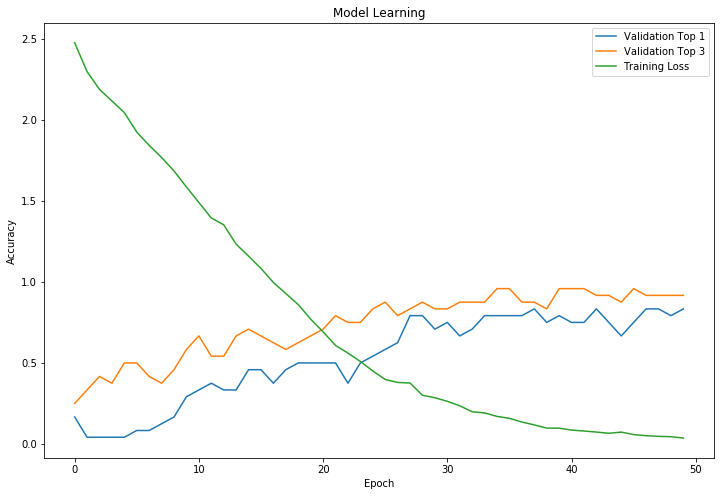

In [107]:
def plot_learning_curve(history):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['val_Top3Acc'])
    plt.plot(history.history['loss'])
    plt.title('Model Learning')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Validation Top 1', 'Validation Top 3', 'Training Loss'], loc='upper right')
    plt.savefig('./accuracy_curve.png')
    plt.show()

plot_learning_curve(history)

# Test on Unseen Video Samples

In [108]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Performace')
print('Loss:', score[0])
print('Top 1 Accuracy:', score[1])
print('Top 3 Accuracy: ', score[2])

30/30 [==============================] - 2s
Test Performace
Loss: 0.560020089149
Top 1 Accuracy: 0.933333396912
Top 3 Accuracy:  0.966666698456


# View Randomly Selected Predictions Next to A Single Video Frame

Predicting on test data
5
Top 3 Predictions: ['SkateBoarding-Front' 'Walk-Front' 'Golf-Swing-Side']
Actual: ['SkateBoarding-Front']


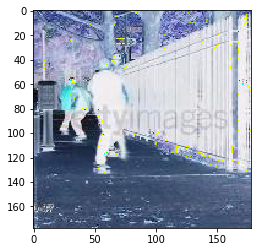

28
Top 3 Predictions: ['Walk-Front' 'Kicking-Side' 'Diving-Side']
Actual: ['Walk-Front']


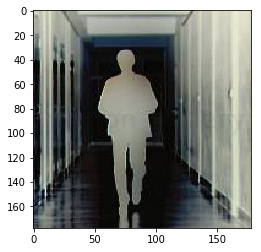

26
Top 3 Predictions: ['Swing-SideAngle' 'Swing-Bench' 'Lifting']
Actual: ['Swing-SideAngle']


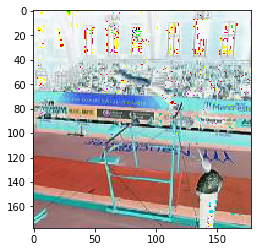

24
Top 3 Predictions: ['Swing-Bench' 'Lifting' 'Golf-Swing-Back']
Actual: ['Swing-Bench']


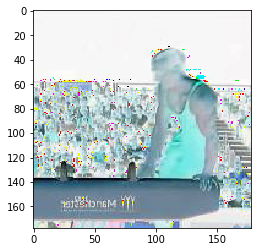

25
Top 3 Predictions: ['SkateBoarding-Front' 'Kicking-Side' 'Run-Side']
Actual: ['SkateBoarding-Front']


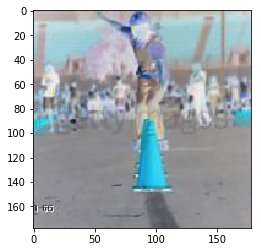

In [109]:
# Test on the out of sample (test) video footage.
X_test = X_test.astype('float32')

print('Predicting on test data')
#y_pred = np.rint(model.predict(X_test))
y_pred = model.predict(X_test)

for i in range(5):
    t = random.randint(0,(len(y_pred)-1))
    print(t)
    print('Top 3 Predictions: ' + str(encoder.classes_[y_pred.argsort()[t][::-1][:3]]))
    print('Actual: ' + str(encoder.classes_[y_test[t]==1]))
    plt.figure()
    plt.imshow(X_test[t][0])
    plt.show()

# Appendix

## Lie Detector Data Section

In [16]:
# Prepare video clips into a resized and cropped series of frames for each video
get_frames_from_videos((VIDEO_FOLDER + '/Deceptive'), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Down sampling video frames.
Getting frames for video 62 of 62

Complete!


In [17]:
# Prepare video clips into a resized and cropped series of frames for each video
get_frames_from_videos((VIDEO_FOLDER + '/Truthful'), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Down sampling video frames.
Getting frames for video 61 of 61

Complete!


In [24]:
# Get video tensors ready for network input
X, y = get_data(VIDEO_FOLDER, FRAMES_PER_VIDEO)

Complete!


In [25]:
X.shape

(119, 30, 178, 178, 3)